In [1]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

## Computer Vision Classification

In [2]:
help(untar_data)

Help on function untar_data in module fastai.data.external:

untar_data(url: 'str', archive: 'Path' = None, data: 'Path' = None, c_key: 'str' = 'data', force_download: 'bool' = False, base: 'str' = '~/.fastai') -> 'Path'
    Download `url` using `FastDownload.get`



In [3]:
dir(URLs)

['ADULT_SAMPLE',
 'AG_NEWS',
 'AMAZON_REVIEWS',
 'AMAZON_REVIEWS_POLARITY',
 'BIWI_HEAD_POSE',
 'BIWI_SAMPLE',
 'CALTECH_101',
 'CAMVID',
 'CAMVID_TINY',
 'CARS',
 'CIFAR',
 'CIFAR_100',
 'COCO_SAMPLE',
 'COCO_TINY',
 'CUB_200_2011',
 'DBPEDIA',
 'DOGS',
 'FLOWERS',
 'FOOD',
 'GOOGLE',
 'HUMAN_NUMBERS',
 'IMAGENETTE',
 'IMAGENETTE_160',
 'IMAGENETTE_320',
 'IMAGEWANG',
 'IMAGEWANG_160',
 'IMAGEWANG_320',
 'IMAGEWOOF',
 'IMAGEWOOF_160',
 'IMAGEWOOF_320',
 'IMDB',
 'IMDB_SAMPLE',
 'LOCAL_PATH',
 'LSUN_BEDROOMS',
 'MACAQUES',
 'MDL',
 'ML_100k',
 'ML_SAMPLE',
 'MNIST',
 'MNIST_SAMPLE',
 'MNIST_TINY',
 'MNIST_VAR_SIZE_TINY',
 'MT_ENG_FRA',
 'OPENAI_TRANSFORMER',
 'PASCAL_2007',
 'PASCAL_2012',
 'PETS',
 'PLANET_SAMPLE',
 'PLANET_TINY',
 'S3',
 'S3_AUDI',
 'S3_COCO',
 'S3_IMAGE',
 'S3_IMAGELOC',
 'S3_MODEL',
 'S3_NLP',
 'SIIM_SMALL',
 'SOGOU_NEWS',
 'TCGA_SMALL',
 'URL',
 'WIKITEXT',
 'WIKITEXT_TINY',
 'WT103_BWD',
 'WT103_FWD',
 'YAHOO_ANSWERS',
 'YELP_REVIEWS',
 'YELP_REVIEWS_POLARITY',
 

In [4]:
path = untar_data(URLs.PETS)/'images'

In [5]:
def is_cat(x):
    return x[0].isupper()

In [6]:
help(ImageDataLoaders.from_name_func)

Help on method from_name_func in module fastai.vision.data:

from_name_func(path: 'str | Path', fnames: 'list', label_func: 'callable', *, valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, img_cls=<class 'fastai.vision.core.PILImage'>, bs: 'int' = 64, val_bs: 'int' = None, shuffle: 'bool' = True, device=None) -> 'DataLoaders' class method of fastai.vision.data.ImageDataLoaders
    Create from the name attrs of `fnames` in `path`s with `label_func`



ImageDataLoaders has other methods like:
1. `from_folder()`
2. `from_path_func()`

Using `from_name_func` because we need to use a custom function operating on name to classify whether the image is of a cat or a dog.

In [7]:
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

`item_tfms` resizes all images to 224x224 pixels

In [8]:
help(vision_learner)

Help on function vision_learner in module fastai.vision.learner:

vision_learner(dls, arch, normalize=True, n_out=None, pretrained=True, weights=None, loss_func=None, opt_func=<function Adam at 0x74e53013fd80>, lr=0.001, splitter=None, cbs=None, metrics=None, path=None, model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95, 0.85, 0.95), cut=None, init=<function kaiming_normal_ at 0x74e664b0dbc0>, custom_head=None, concat_pool=True, pool=True, lin_ftrs=None, ps=0.5, first_bn=True, bn_final=False, lin_first=False, y_range=None, *, n_in=3)
    Build a vision learner from `dls` and `arch`



In [9]:
help(error_rate)

Help on function error_rate in module fastai.metrics:

error_rate(inp, targ, axis=-1)
    1 - `accuracy`



In [10]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.158049,0.023658,0.010149,01:43


epoch,train_loss,valid_loss,error_rate,time
0,0.056825,0.022682,0.006089,02:30


In [11]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.156288,0.027299,0.008119,01:47


epoch,train_loss,valid_loss,error_rate,time
0,0.066739,0.025589,0.008119,02:32
1,0.026200,0.017719,0.006089,02:31


## FastAI Fine-Tuning Process

1. Freezing and Unfreezing:
   - Initially, all layers of the pre-trained model (ResNet34 in this case) are frozen except the final layer(s).
   - The model trains only the final layer(s) for one epoch to adapt to the new dataset.
   - Then, it gradually unfreezes more layers of the model.
2. Learning Rate Selection:
   - The fine_tune method automatically selects appropriate learning rates for different parts of the model.
   - It uses the "discriminative learning rates" technique, where earlier layers (more general features) have lower learning rates, and later layers (more specific features) have higher learning rates.
3. Training Phases:
   - Phase 1: Train only the newly added layers (usually just the final layer) for one epoch.
   - Phase 2: Train the entire model for the specified number of epochs (1 in this case) using the discriminative learning rates.
4. Data Augmentation:
   - During training, it applies the data augmentation techniques specified in the DataLoaders object.
5. Validation:
   - After each epoch, it evaluates the model on the validation set and computes the specified metrics (error rate in this case).
6. Early Stopping:
   - If enabled, it can stop training early if the validation metrics stop improving.
|
The fine_tune method encapsulates best practices for transfer learning, making it easier to achieve good results quickly on a new dataset using a pre-trained model.

## What are epochs?

An epoch represents one complete pass through the entire training dataset. During an epoch:
1. The model processes every sample in the training set once.
2. The model's parameters are updated based on the calculated loss
3. The model's performance is typically evaluated on the validation set

## Effects of increasing epochs in fine_tune()

The model will see the entire dataset twice during fine-tuning, which gives more opportunities to learn from the data and can result in better performance and lower error rates. For smaller datasets, more epochs increase the risk of overfitting.

## One-Cycle Learning Rate Policy in FastAI

The one-cycle learning rate policy is a technique introduced by Leslie Smith and implemented in FastAI. It involves changing the learning rate (and momentum) throughout training in a specific pattern.

### Learning Rate Variation:
1. Start with a low learning rate
2. Gradually increase to a maximum value
3. Decrease to a very low value

### Momentum Variation
1. Momentum is varied inversely to the learning rate
2. Starts high, decreases as LR increases, then increases again

### Phases in one-cycle policy

1. Warmup phase
   - LR increases from low to high
   - Momentum decreases from high to low
2. Annealing Phase
   - LR decreases from high back to low
   - Momentum increases from low back to high
  
### Benefits

 - Faster convergence
 - Potential for better generalization
 - Can help avoid getting stuck in local minima
 - Often allows for higher maximum learning rates

### Implementation in FastAI

 - FastAI automatically determines suitable learning rate ranges
 - The policy is applied throughout the specified number of epochs
 - When epochs are increased, the cycle is extended over more iterations

### Effects of increasing epochs

 - With more epochs, the LR changes more slowly
 - This can allow for a more thorough exploration of the loss landscape
 - May lead to better convergence, especially on complex datasets

In [12]:
help(PILImage)

Help on class PILImage in module fastai.vision.core:

class PILImage(PILBase)
 |  A RGB Pillow `Image` that can show itself and converts to `TensorImage`
 |
 |  Method resolution order:
 |      PILImage
 |      PILBase
 |      PIL.Image.Image
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  dihedral(x: 'PILImage', k: 'int') from fastai.vision.augment.PILImage
 |      # %% ../../nbs/09_vision.augment.ipynb 21
 |
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |
 |  __annotations__ = {}
 |
 |  __signature__ = <Signature ()>
 |
 |  ----------------------------------------------------------------------
 |  Methods inherited from PILBase:
 |
 |  __repr__(self)
 |      Return repr(self).
 |
 |  show(self, ctx=None, **kwargs)
 |      Show image using `merge(self._show_args, kwargs)`
 |
 |  ----------------------------------------------------------------------
 |  Class methods inherited from PILBase:
 |
 |  cre

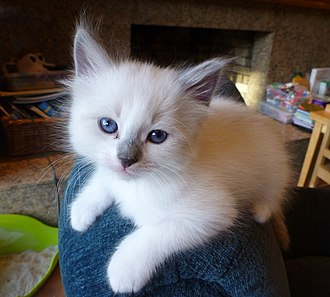

In [13]:
img = PILImage.create('images/cat.jpg')
img

In [14]:
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: True.
Probability it's a cat: 1.000000


In [15]:
doc(learn.predict)

## Computer Vision Segmentation

Resnet35 can serve multiple roles depending on the context:
1. As a standalone model architecture
    - Used for image classification tasks
    - Contains 34 layers
    - Includes convolutional layers, pooling, and fully connected layers
2. As an encoder (backbone):
    - Used in more complex architectures like U-net
    - Provides feature extraction capabilities
    - Typically uses only the convolutional and pooling layers
  
In vision learner, resnet34 serves as the complete model architecture and only final layers are adapted for the specific task.

In unet learner, resnet34 serves as the encoder and additional layers are added to create u-net structure.

In [16]:
help(unet_learner)

Help on function unet_learner in module fastai.vision.learner:

unet_learner(dls, arch, normalize=True, n_out=None, pretrained=True, weights=None, config=None, loss_func=None, opt_func=<function Adam at 0x74e53013fd80>, lr=0.001, splitter=None, cbs=None, metrics=None, path=None, model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95, 0.85, 0.95), *, cut=None, n_in=3, blur=False, blur_final=True, self_attention=False, y_range=None, last_cross=True, bottle=False, act_cls=<class 'torch.nn.modules.activation.ReLU'>, init=<function kaiming_normal_ at 0x74e664b0dbc0>, norm_type=None)
    Build a unet learner from `dls` and `arch`



In [17]:
doc(unet_learner)

In [18]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,3.066132,2.785755,00:04


epoch,train_loss,valid_loss,time
0,2.082104,1.892391,00:05
1,1.805764,1.437537,00:05
2,1.554648,1.224082,00:05
3,1.472400,1.555557,00:05
4,1.391723,1.157361,00:05
5,1.278426,1.083239,00:05
6,1.170281,0.996080,00:05
7,1.074202,0.958956,00:05
8,0.993161,0.929272,00:05
9,0.928113,0.925584,00:05


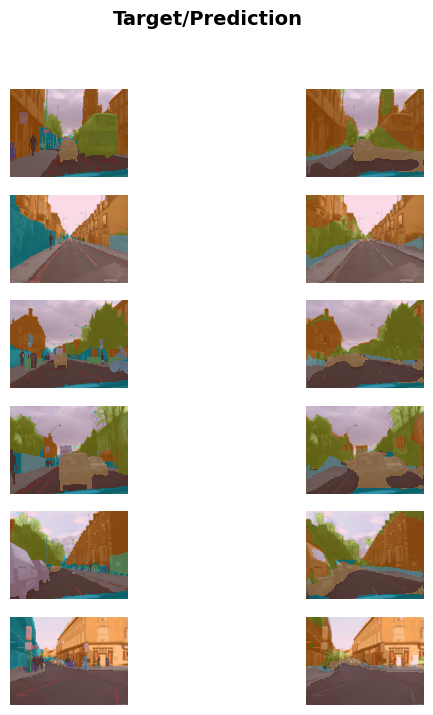

In [19]:
learn.show_results(max_n=6, figsize=(7,8))

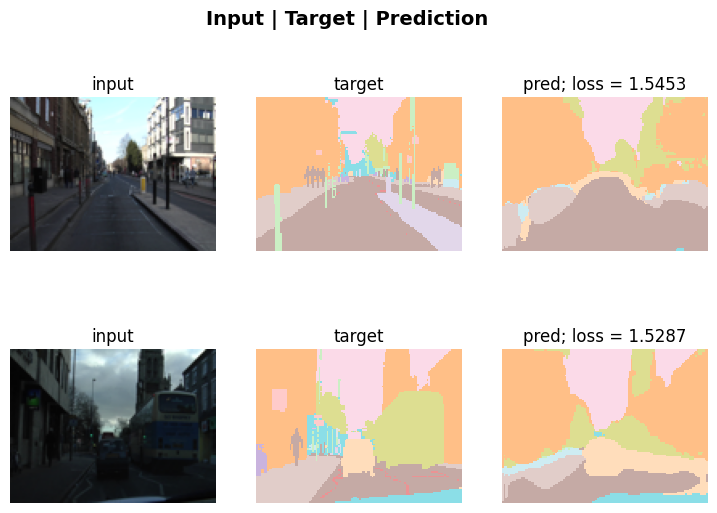

In [20]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=2)

## Natural Language Processing

In [21]:
from fastai.text.all import *
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

TypeError: ForwardRef._evaluate() missing 1 required keyword-only argument: 'recursive_guard'

In [ ]:
learn.predict("I really liked that movie!")

## Tabular

In [22]:
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(2)

/home/work/Codes/fastai-learning/.venv/lib/python3.12/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


epoch,train_loss,valid_loss,accuracy,time
0,0.371523,0.370820,0.828317,00:01
1,0.357594,0.362882,0.833999,00:01


## Recommendation Systems

In [23]:
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(6)

epoch,train_loss,valid_loss,time
0,1.489314,1.478186,00:00


epoch,train_loss,valid_loss,time
0,1.347047,1.389885,00:00
1,1.162749,1.077443,00:00
2,0.873662,0.858807,00:00
3,0.723280,0.804337,00:00
4,0.657267,0.792559,00:00
5,0.640969,0.790985,00:00


In [24]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,53.0,22.0,3.0,3.949391
1,14.0,45.0,4.0,3.811925
2,84.0,55.0,4.0,3.658160
3,39.0,98.0,4.0,3.952189
4,79.0,14.0,4.0,4.399419
5,50.0,22.0,3.0,3.316601
6,47.0,96.0,4.0,3.817212
7,62.0,32.0,3.0,3.194288
8,63.0,8.0,3.0,3.100510


## Choosing Metrics: Accuracy vs Error Rate

### Accuracy
- Definition: Proportion of correct predictions
- Use when:
  - You want a straightforward, intuitive metric
  - Classes are roughly balanced
  - All types of errors are equally important

### Error Rate
- Definition: Proportion of incorrect predictions (1 - Accuracy)
- Use when:
  - You want to focus on mistakes
  - It aligns better with your loss function
  - You're comparing to models traditionally evaluated with error rate

### In Practice
- Accuracy and error rate convey the same information
- Choice often depends on the field's conventions or personal preference

### Segmentation Tasks
- Common metrics: IoU (Intersection over Union), Dice coefficient
- These metrics are often set as defaults in segmentation learners
- Custom metrics can be added if needed

Remember: The choice of metric should align with your project's goals and the nature of your data.

## Examples: When to Use Accuracy vs Error Rate

### 1. Email Spam Classification
- Metric: Accuracy
- Reason: Intuitive for stakeholders ("97% of emails correctly classified")
- Example: `metrics=accuracy`

### 2. Medical Diagnosis
- Metric: Error Rate
- Reason: Focus on minimizing misdiagnoses
- Example: `metrics=error_rate`

### 3. Product Quality Control
- Metric: Error Rate
- Reason: Emphasizes defect rate, aligns with "Six Sigma" methodology
- Example: `metrics=error_rate`

### 4. Image Classification Competition
- Metric: Accuracy
- Reason: Often the standard metric in competitions (e.g., ImageNet)
- Example: `metrics=accuracy`

### 5. Fraud Detection
- Metric: Both
- Reason: Accuracy for overall performance, Error Rate for risk assessment
- Example: `metrics=[accuracy, error_rate]`

### 6. Sentiment Analysis
- Metric: Accuracy
- Reason: Intuitive for reporting ("85% of sentiments correctly identified")
- Example: `metrics=accuracy`

Remember: The choice often depends on how you want to frame and communicate your results.

## Dropout Multiplication Factor

### Overview
The dropout multiplication factor is a hyperparameter used to adjust the intensity of dropout across an entire model.

### Key Points
1. Definition: A scalar value that multiplies the default dropout rates in a model.
2. Purpose: Allows easy adjustment of overall regularization strength.
3. Usage: Typically set between 0 and 1, where:
   - 0 means no dropout
   - 1 means using the model's default dropout rates
   - Values > 1 increase dropout beyond default rates
4. Advantage: Enables quick experimentation with different levels of regularization.

### In Practice
- Used in FastAI's `learner` functions (e.g., `text_classifier_learner`)
- Affects all dropout layers in the model
- Helps in finding the right balance between underfitting and overfitting

### Example
```python
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5)
```
This sets dropout rates to half of their default values across the model.

## AWD-LSTM (ASGD Weight-Dropped LSTM) Architecture

### Overview
AWD-LSTM is an advanced recurrent neural network architecture designed for language modeling tasks. It incorporates several techniques to improve performance and reduce overfitting.

### Key Components

1. LSTM (Long Short-Term Memory) Base:
   - Solves vanishing gradient problem in standard RNNs
   - Contains gates: input, forget, output, and cell state

2. Weight Dropping:
   - Applies dropout to hidden-to-hidden weights
   - Reduces overfitting without significantly slowing training

3. ASGD (Averaged Stochastic Gradient Descent):
   - Averaging of SGD iterations for better convergence
   - Improves generalization

4. Variable Length Backpropagation Sequences:
   - Varies the sequence length during training
   - Helps model learn both short and long-range dependencies

5. Embedding Dropout:
   - Applies dropout to the embedding layer
   - Encourages the model to rely on a diverse set of words

6. Additional Regularization:
   - L2 regularization and temporal activation regularization
   - Further prevents overfitting

### Architecture Flow
1. Input → Embedding Layer (with dropout)
2. Embedding → LSTM Layers (with weight dropping)
3. LSTM Layers → Output Layer
4. Training with ASGD and variable length sequences

### Advantages
- Strong performance on language modeling tasks
- Effective regularization for NLP
- Balances learning of short and long-range dependencies